In [119]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT（如果DICOM设备可用）用于将原始DICOM数据转换为“人性化”视图
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # 根据这个值，X射线可能看起来是反向的修复这个问题:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


In [26]:
import sys
print(sys.version)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 016bc723c3ceedb78e27ebfe7032498e
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 2430
(0028, 0011) Columns                             US: 1994
(0028, 0030) Pixel Spacing            

(7fe0, 0010) Pixel Data                          OB: Array of 5762690 elements
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 164
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 01f8f17dba6c5e67ba5bcf30ce70ea3f
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'INF_3.9'
(0002, 0016) Source Application Entity Title     AE: 'Eleva'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1020) Patient's Size                      DS: "0.0"
(0010, 1030) Patient's Weight                    DS: "0.0"
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) 

(7fe0, 0010) Pixel Data                          OB: Array of 5869808 elements


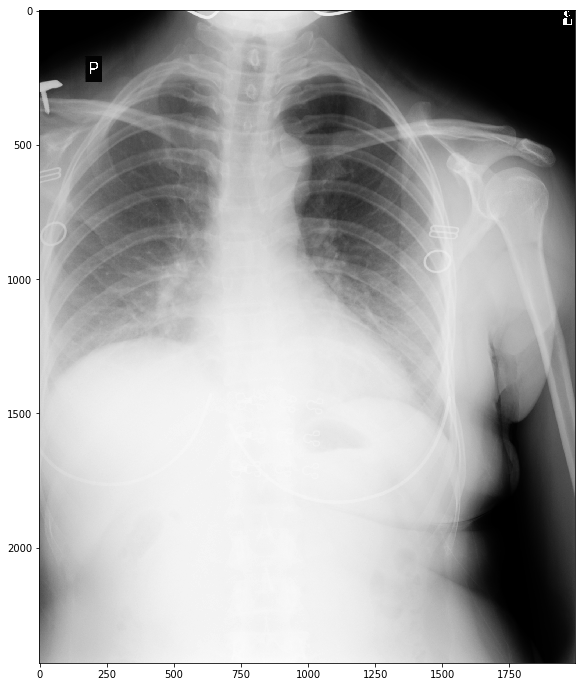

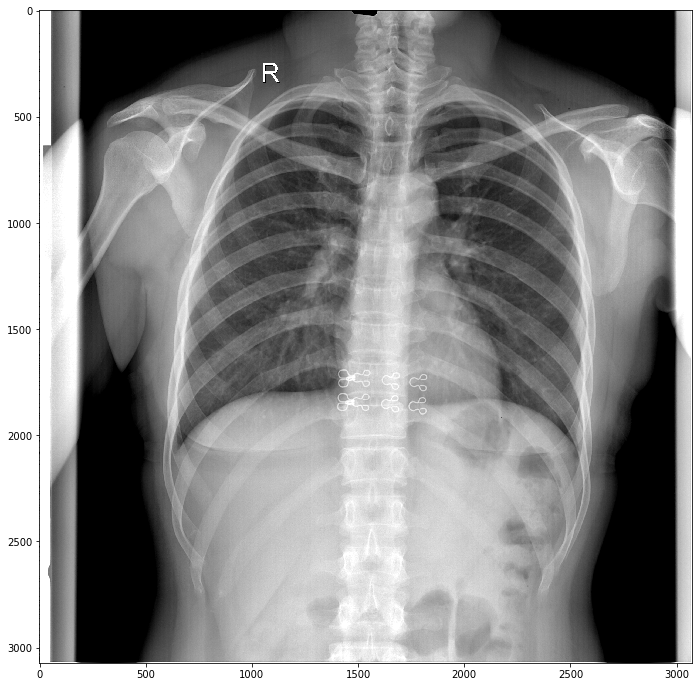

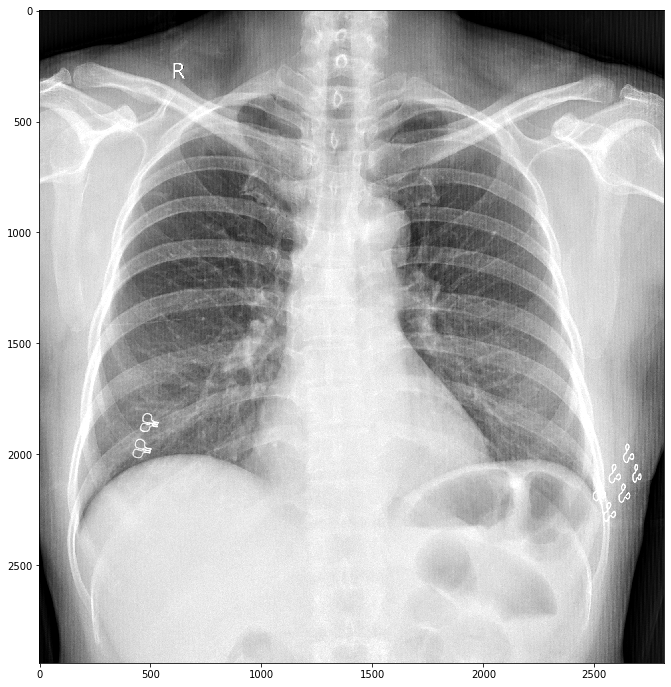

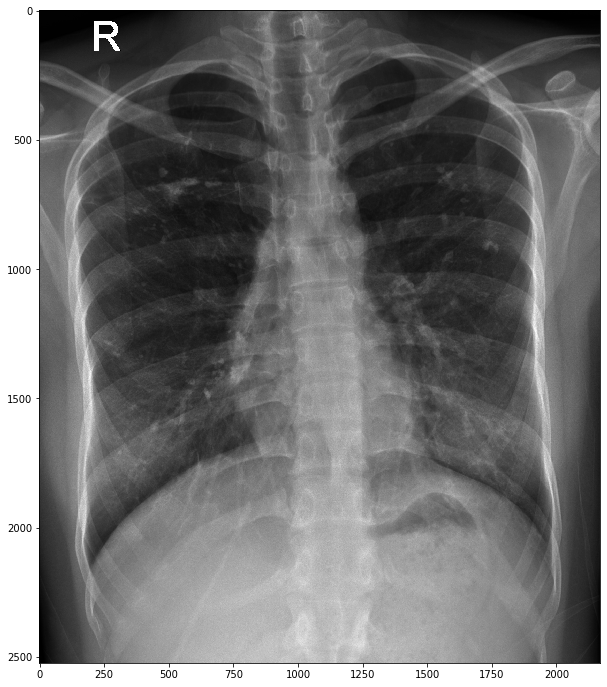

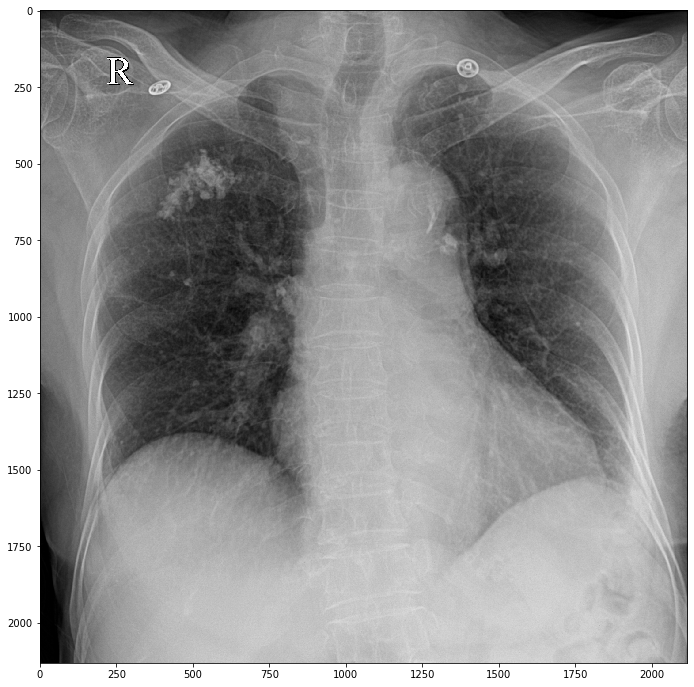

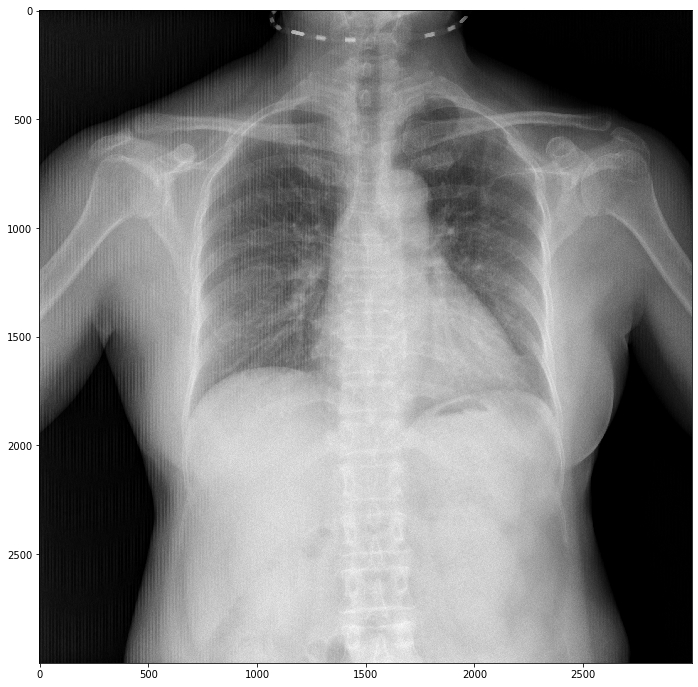

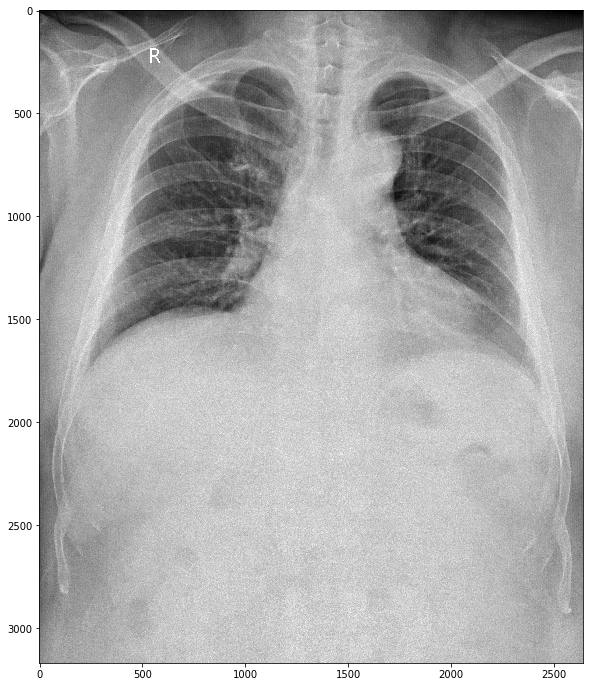

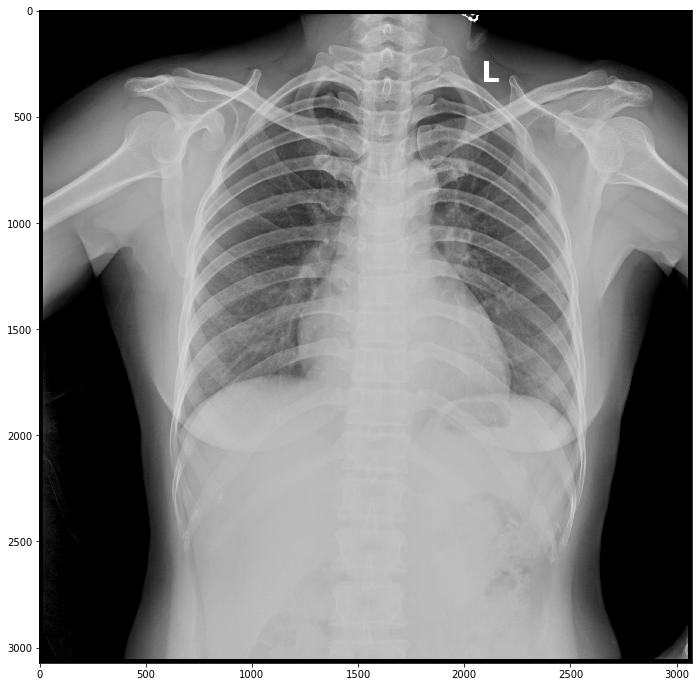

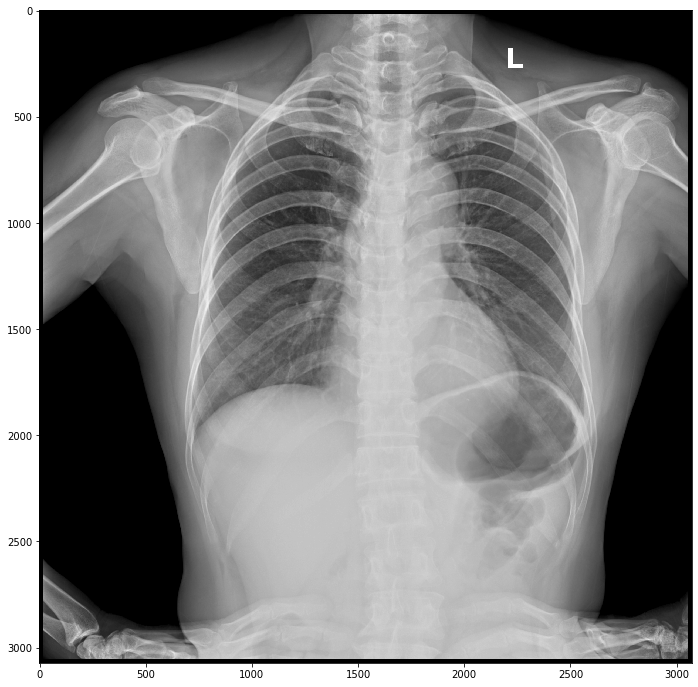

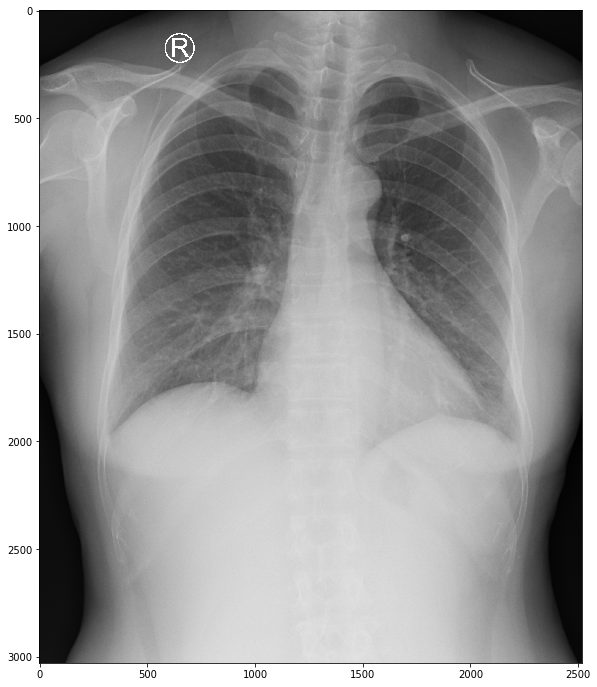

In [27]:
import os
files = os.listdir("test")[10:20]
for f in files:
    try:
        img = read_xray("test\\" + f)
        plt.figure(figsize = (12,12))
        plt.imshow(img, 'gray')
    except NotImplementedError:
        print(f"NotImplementedError for {f}")

In [1]:
# import imageio
# imageio.plugins.freeimage.download()

Imageio: 'freeimage-3.15.1-win64.dll' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/FreeImage-3.15.1-win64.dll (3.4 MB)
Downloading: 8192/3527168 bytes (0.2%2195456/3527168 bytes (62.2%3527168/3527168 bytes (100.0%)
  Done
File saved as C:\Users\hower\AppData\Local\imageio\freeimage\freeimage-3.15.1-win64.dll.


In [15]:
from bokeh.plotting import figure as bokeh_figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import random
from random import randint

In [ ]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])

train_df = pd.read_csv(f'{dataset_dir}/train.csv')
le = preprocessing.LabelEncoder()  # encode rad_id
train_df['rad_label'] = le.fit_transform(train_df['rad_id'])

finding_df = train_df[train_df['class_name'] != 'No finding']
finding_df['bbox_area'] = finding_df.apply(get_bbox_area, axis=1)
finding_df.head()

In [14]:
imgs = []
img_ids = finding_df['image_id'].values
class_ids = finding_df['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


for i in range(8):
    img_id = random.choice(img_ids)
    img_path = f'{dataset_dir}/train/{img_id}.dicom'
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    boxes = finding_df.loc[finding_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values/scale
    labels = finding_df.loc[finding_df['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

NameError: name 'finding_df' is not defined

# Preprocessing

In [13]:
import cv2 # video frame extraction
import csv
import warnings
from glob import glob
from pathlib import Path
import numpy as np
import os, shutil, PIL, json, threading
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, sampler

from torchvision import transforms, utils, models
import torchvision.datasets as dset
import torchvision.transforms as T

In [10]:
class ChestDataset(Dataset):
    """Chest X-ray dataset."""
    self.trainMode = 0
    self.testMode = 1

    def __init__(self, filePath, imageSize = 200, purpose):
        """
        Args:
            filePath (string): Directory with all the images.
            purpose (string): two option to choose from {train = 0, test = 1}
        """
        self.files = sorted(glob('%s/*.*' % filePath))
        self.purpose = purpose
        self.imageShape = (imageSize, imageSize)


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        
        imagePath = self.filePath "//" + self.catalog[idx] + ".dicom" # 获取图片路径
        image = np.array(read_xray(imagePath))
        
        # Padding
        height, width, dim = image.shape
        hw_diff = np.abs(height - width)
        pad1, pad2 = hw_diff//2, dim_diff - hw_diff//2
        pad = ((pad1, pad2), (0,0), (0,0)) if h<=w else ((0,0), (pad1, pad2), (0,0))        
        paddedImage = np.pad(img, pad, 'constant', constant_values=128) / 255
        
        padded_height, padded_width, _ = paddedImage.shape
        paddedImage = resize(paddedImage, (*self.img_shape, 1), mode='reflect')
        paddedImage = np.transpose(paddedImage, (2, 0, 1))
        paddedImage = torch.from_numpy(paddedImage).float()


        if purpose == self.testMode:
            return imagePath, paddedImage

        self.readMetadata(filePath+'.csv')
        # 后面没写完
        x1 = w * (labels[:, 1] - labels[:, 3] / 2) # 先获取box左上角和右下角的像素坐标
        y1 = h * (labels[:, 2] - labels[:, 4] / 2)
        x2 = w * (labels[:, 1] + labels[:, 3] / 2)
        y2 = h * (labels[:, 2] + labels[:, 4] / 2)

        # 根据 padding 的大小, 更新这些坐标的值
        x1 += pad[1][0]
        y1 += pad[0][0]
        x2 += pad[1][0]
        y2 += pad[0][0]

        # 重新将坐标转化成小数模式(相对应padding后的宽高的比例)
        labels[:, 1] = ((x1+x2)/2) / padded_w
        labels[:, 2] = ((y1+y2)/2) / padded_h
        labels[:, 3] *= w / padded_w
        labels[:, 4] *= h / padded_h
        filled_labels = np.zeros((self.max_objects, 5)) # 创建50×5的占位空间
        if labels is not None: # 将更新后的box坐标填充到刚刚申请的占位空间中
            filled_labels[range(len(labels))[:self.max_objects]] = labels[:self.max_objects]
        # 将 label 转化成 tensor
        filled_labels =torch.from_numpy(filled_labels)

         return img_path, input_img, filled_labels

    
    def readMetadata(self, file):
        self.metadata = {}
        with open(file) as csvfile:
            dict_reader = csv.DictReader(csvfile, delimiter=',')
            for orderedDict in dict_reader:
                d = dict(orderedDict)
                iamge_id = d["iamge_id"]
                del d["iamge_id"]
                d["class_id"] = int(d["class_id"])
                d["x_min"] = float(d["x_min"]) if d["x_min"] != "" else 0 # x_min is string type by default, so change it to float type
                d["x_max"] = float(d["x_max"]) if d["x_max"] != "" else 0
                d["y_min"] = float(d["y_min"]) if d["y_min"] != "" else 0
                d["y_max"] = float(d["y_max"]) if d["y_max"] != "" else 0
                self.metadata[iamge_id] = d

    def read_xray(self, path, voi_lut = True, fix_monochrome = True):
        dicom = pydicom.read_file(path)

        # VOI LUT（如果DICOM设备可用）用于将原始DICOM数据转换为“人性化”视图
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array

        # 根据这个值，X射线可能看起来是反向的修复这个问题:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data

        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)

        return data



In [11]:
trainDatasetPath = Path("train/")
dataset = ChestDataset(trainDatasetPath)

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "
C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


KeyboardInterrupt: 

## Splitting Dataset

In [112]:
trainSize = round(0.75 * len(dataset))
verifySize = len(dataset) - trainSize
print(f"{len(dataset)} images in total.\n{trainSize} images are in training set;\ {verifySize} images are in verify set.")
train_set, verify_set = torch.utils.data.random_split(dataset, [trainSize, verifySize])

In [ ]:
loader_train = DataLoader(train_set, batch_size = 64)
loader_verify = DataLoader(verify_set, batch_size = 64)
loader_test = DataLoader(dataset, batch_size = 64)

## Training

In [10]:
print_every = 150
def resetParam(model):
    if hasattr(model, 'reset_parameters'):
        model.reset_parameters()

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [12]:
def check_accuracy(model, loader):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    confusion_matrix = []
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        with torch.no_grad():
            x_var = Variable(x.type(gpu_dtype))
        
        _, preds = model(x_var).data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    return acc, confusion_matrix

In [14]:
def train(model, modelName: str, loader, loader_verify, loss_fn, optimizer, num_epochs = 1):
    train_acc = []
    ver_acc = []
    loss_graph = []
    modelFolder = os.getcwd() + f"\\model_state\\{modelName}\\"
    if not Path(modelFolder).exists():
        os.mkdir(modelFolder)
    
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            
            loss = loss_fn(scores, Variable(y.type(gpu_dtype).long()))
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.10f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_graph.append(loss.item())
        ta, _ = check_accuracy(model, loader)
        train_acc.append(ta)
        vc, _ = check_accuracy(model, loader_verify)
        ver_acc.append(vc)
        
        torch.save(model.state_dict(), modelFolder+f"\\model_epoch_{epoch}")
        
    plt.plot(range(num_epochs),train_acc, 's-',color = 'blue',label="Train Accuracy")
    plt.plot(range(num_epochs),ver_acc, 'o-',color = 'orange',label="Verify Accuracy")
    plt.show()
    plt.plot(range(num_epochs), loss_graph, color = 'blue',label="Train Loss" )
    plt.show()         

### YOLO

In [5]:
%run ConvertDicom2JPG.py

In [1]:
%run label_to_txt.py

In [ ]:
%run train.py

log file path:log\log_2021-02-24_23-09-39.txt
2021-02-24 23:09:39,522 train.py[line:611] INFO: Using device cuda
2021-02-24 23:09:41,124 train.py[line:327] INFO: Starting training:
        Epochs:          1
        Batch size:      2
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   3296
        Validation size: 1098
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 14
        Train label path:data/train.txt
        Pretrained:
    


Epoch 1/1:   1%| | 38/3296 [01:20<3:53:09,  4.29s/img]C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Epoch 1/1: 100%|█| 3296/3296 [30:52<00:00,  2.04img/s, loss (batch)=632, loss_cls=108, loss_l2=120, loss_obj=382, loss_wh=20.6, loss_xy=120, lr=0.001]                

in function convert_to_coco_api...
creating index...
index created!


In [ ]:
%run model.py